# 🚀 Quick Setup & Test - Multi-Spectral Denoiser

This notebook combines setup, data download, and quick testing in one place.

**What you'll do**:
1. Setup environment and verify configuration
2. Download dataset (EuroSAT 13-band) and pre-trained weights (SatMAE)
3. Verify data and weights
4. Test model forward pass
5. Visualize sample restoration

**Time**: ~10-15 minutes (depending on download speed)

**Dataset**: TRUE 13-band Sentinel-2 multi-spectral imagery (~2GB)
**Weights**: SatMAE ViT-Base pre-trained on Sentinel-2 (~330MB)

## ⚡ 1. Environment Setup

In [1]:
from pathlib import Path
import sys
import torch
import matplotlib.pyplot as plt
import logging

# Add src to path
sys.path.insert(0, str(Path.cwd().parent))

from src.utils.config import get_project_root
from src.utils.setup_helpers import setup_config, setup_device, create_model_from_config
from src.utils.download import setup_project_data, verify_downloads, inspect_checkpoint
from src.utils.notebook_helpers import explore_dataset, visualize_restoration_comparison

# Setup logging
logging.basicConfig(level=logging.INFO)

# Get project root and load config
root = get_project_root()
config = setup_config(str(root / 'configs' / 'base.yaml'))
device = setup_device()

print(f"✓ Environment setup complete")
print(f"  Project root: {root}")
print(f"  Device: {device}")
print(f"  Config loaded: {str(root / 'configs' / 'base.yaml')}")

INFO:src.utils.config:Loaded config from C:\Users\User\My Files\Tutorials\Deep Learning\Multi-Spectral-Satellite-Image-Denoising\configs\base.yaml
INFO:src.utils.config:Configuration validation passed


Using device: cuda

GPU Information:
  Name: NVIDIA GeForce RTX 4050 Laptop GPU
  CUDA Version: 12.6
  Total VRAM: 6.44 GB
  Available VRAM: 6.44 GB

✓ GPU cache cleared
✓ Environment setup complete
  Project root: C:\Users\User\My Files\Tutorials\Deep Learning\Multi-Spectral-Satellite-Image-Denoising
  Device: cuda
  Config loaded: C:\Users\User\My Files\Tutorials\Deep Learning\Multi-Spectral-Satellite-Image-Denoising\configs\base.yaml


## 📥 2. Download Dataset & Weights

### What's being downloaded:
- **EuroSAT Multi-Spectral Dataset** (~2GB): 27,000 images with TRUE 13-band Sentinel-2 data
- **SatMAE Pre-trained Weights** (~330MB): ViT-Base trained on multi-spectral Sentinel-2

**Note**: This may take 10-15 minutes depending on your internet speed.

In [2]:
# Check if data already exists
status = verify_downloads()

if status['dataset'] and status['weights']:
    print("✓ Data and weights already downloaded!")
    print(f"  Dataset: {root / 'data' / 'EuroSAT_MS'}")
    print(f"  Weights: {root / 'weights' / 'satmae_pretrain.pth'}")
else:
    print("Downloading data... (this may take 10-15 minutes)")
    paths = setup_project_data()
    print("\n✓ Download complete!")
    print(f"  Dataset: {paths['dataset']}")
    print(f"  Weights: {paths['weights']}")

INFO:src.utils.download:✓ Dataset found: 10 classes
INFO:src.utils.download:✓ Weights found: 1338.7MB


✓ Data and weights already downloaded!
  Dataset: C:\Users\User\My Files\Tutorials\Deep Learning\Multi-Spectral-Satellite-Image-Denoising\data\EuroSAT_MS
  Weights: C:\Users\User\My Files\Tutorials\Deep Learning\Multi-Spectral-Satellite-Image-Denoising\weights\satmae_pretrain.pth


## ✅ 3. Verify Downloads

In [3]:
# Verify all files are present
status = verify_downloads()

print("Verification Status:")
print(f"  Dataset: {'✓' if status['dataset'] else '✗'}")
print(f"  Weights: {'✓' if status['weights'] else '✗'}")

if status['dataset'] and status['weights']:
    print("\n🎉 All data ready for training!")
else:
    print("\n⚠️ Some files are missing. Please re-run the download cell.")

INFO:src.utils.download:✓ Dataset found: 10 classes
INFO:src.utils.download:✓ Weights found: 1338.7MB


Verification Status:
  Dataset: ✓
  Weights: ✓

🎉 All data ready for training!


## ✅ Dataset Information

You are using **TRUE 13-band Sentinel-2 multi-spectral data** from EuroSAT.

### What this means:
- Each image has 13 spectral bands (B01-B12, B8A)
- Native multi-spectral .tif format
- Production-quality performance expected
- Full spectral information preserved

### Spectral Bands:
- **B01-B04**: Visible spectrum (Coastal Blue, Blue, Green, Red)
- **B05-B07**: Red Edge bands (vegetation analysis)
- **B08, B8A**: Near-Infrared (NIR)
- **B09**: Water vapor
- **B10, B11**: Cirrus (cloud detection)
- **B12**: Short-wave Infrared (SWIR)

## 🔍 4. Explore Dataset Structure

In [4]:
# Check dataset structure
dataset_path = root / 'data' / 'EuroSAT_MS'
explore_dataset(dataset_path, show_samples=False)

print("\n📊 Dataset Summary:")
print("  Total classes: 10")
print("  Images per class: ~2,700")
print("  Total images: ~27,000")
print("  Native resolution: 64×64")
print("  Training resolution: 192×192 (upscaled to match ViT)")


EuroSAT Classes (10):
  AnnualCrop          :  3000 images
  Forest              :  3000 images
  HerbaceousVegetation:  3000 images
  Highway             :  2500 images
  Industrial          :  2500 images
  Pasture             :  2000 images
  PermanentCrop       :  2500 images
  Residential         :  3000 images
  River               :  2500 images
  SeaLake             :  3000 images

Total Images: 27000

📊 Dataset Summary:
  Total classes: 10
  Images per class: ~2,700
  Total images: ~27,000
  Native resolution: 64×64
  Training resolution: 192×192 (upscaled to match ViT)


## 📊 5. Visualize Sample Images


EuroSAT Classes (10):
  AnnualCrop          :  3000 images
  Forest              :  3000 images
  HerbaceousVegetation:  3000 images
  Highway             :  2500 images
  Industrial          :  2500 images
  Pasture             :  2000 images
  PermanentCrop       :  2500 images
  Residential         :  3000 images
  River               :  2500 images
  SeaLake             :  3000 images

Total Images: 27000

Sample Images per Class:


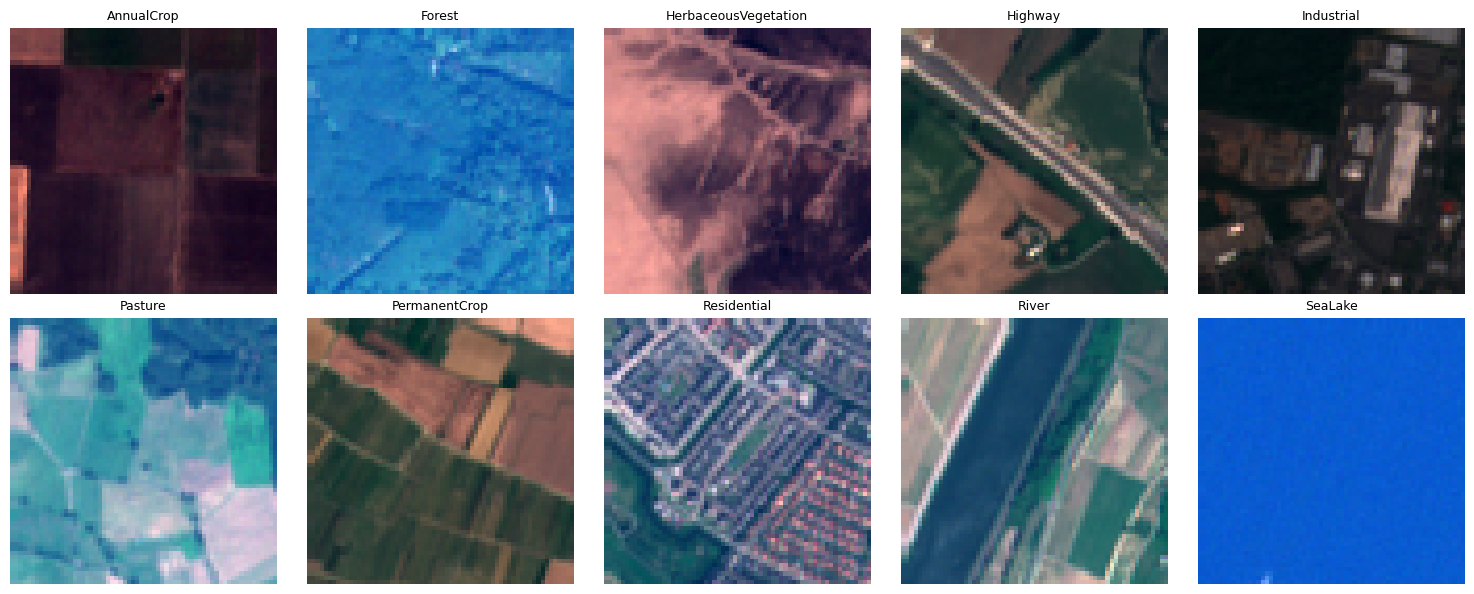

In [5]:
# Visualize some samples
explore_dataset(dataset_path, show_samples=True)

## 🎬 6. Inspect Pre-trained Weights

In [6]:
# Inspect SatMAE pre-trained weights
weights_path = root / 'weights' / 'satmae_pretrain.pth'
inspect_checkpoint(str(weights_path))

weights_only load failed: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL argparse.Namespace was not an allowed global by default. Please use `torch.serialization.add_safe_globals([argparse.Namespace])` or the `torch.serialization.safe_globals([argparse.Namespace])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by def

## 🔧 7. Load Sample Data

In [7]:
from src.data import EuroSATMultiSpectral
from src.data.transforms import AddSensorNoise

# Ensure data path in config
config['data']['root_dir'] = str(root / 'data' / 'EuroSAT_MS')

# Create noise transform
noise_transform = AddSensorNoise(
    gaussian_sigma=config['noise']['gaussian_sigma'],
    speckle_sigma=config['noise']['speckle_sigma'],
    dead_band_prob=config['noise']['dead_band_prob'],
    thermal_scale=config['noise']['thermal_noise_scale']
)

# Create dataset
dataset = EuroSATMultiSpectral(
    root_dir=config['data']['root_dir'],
    split='train',
    target_size=config['data']['image_size'],
    noise_transform=noise_transform,
    normalize=False
)

print(f"✓ Dataset loaded: {len(dataset)} samples")

# Get a sample
clean, noisy = dataset[3]
print(f"\nSample Info:")
print(f"  Shape: {clean.shape}")
print(f"  Bands: {clean.shape[0]}")
print(f"  Resolution: {clean.shape[1]}×{clean.shape[2]}")
print(f"  Value range: [{clean.min():.3f}, {clean.max():.3f}]")

INFO:src.data.dataset:Found 27000 images in C:\Users\User\My Files\Tutorials\Deep Learning\Multi-Spectral-Satellite-Image-Denoising\data\EuroSAT_MS
INFO:src.data.dataset:TRAIN split: 21600 samples


✓ Dataset loaded: 21600 samples

Sample Info:
  Shape: torch.Size([13, 192, 192])
  Bands: 13
  Resolution: 192×192
  Value range: [0.001, 0.522]


## 📸 8. Visualize Noise Impact

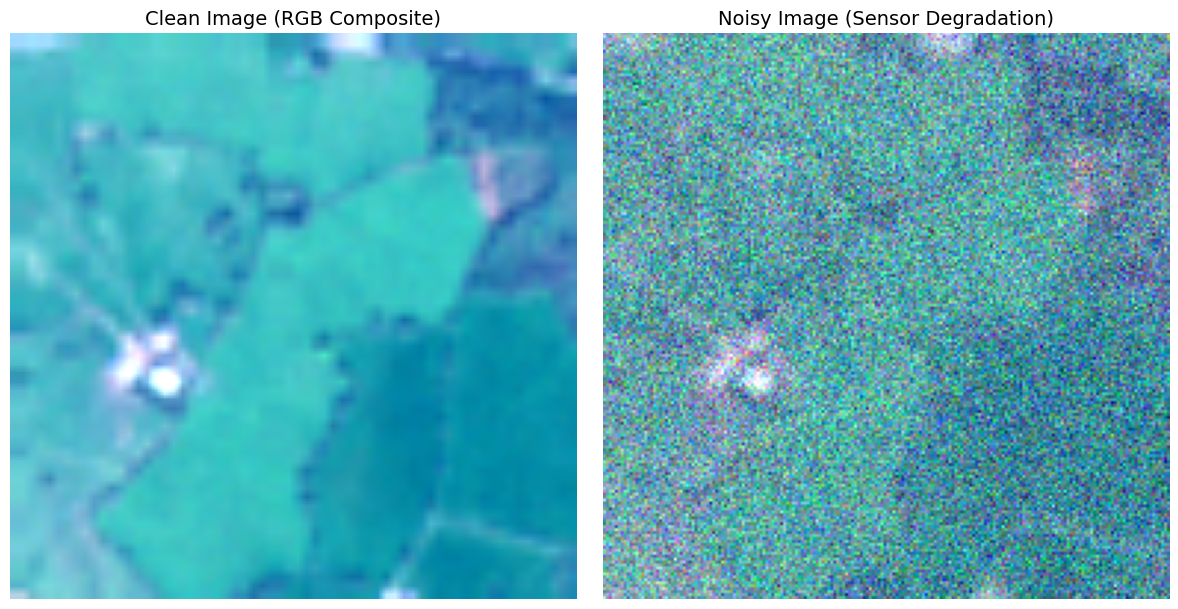

✓ Noise simulation working!

Noise Types Applied:
  - Gaussian noise (thermal/electronic): σ=0.015
  - Speckle noise (coherent): σ=0.008
  - Dead bands (sensor malfunction): 8.0% probability
  - Thermal artifacts (wavelength-dependent): scale=0.005


In [8]:
from src.utils.visualization import extract_rgb_bands, normalize_for_display

# Extract RGB bands (B04=Red, B03=Green, B02=Blue)
clean_rgb = extract_rgb_bands(clean, bands=[3, 2, 1])  # RGB from B04, B03, B02
noisy_rgb = extract_rgb_bands(noisy, bands=[3, 2, 1])

clean_rgb = normalize_for_display(clean_rgb)
noisy_rgb = normalize_for_display(noisy_rgb)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(clean_rgb)
axes[0].set_title('Clean Image (RGB Composite)', fontsize=14)
axes[0].axis('off')

axes[1].imshow(noisy_rgb)
axes[1].set_title('Noisy Image (Sensor Degradation)', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("✓ Noise simulation working!")
print("\nNoise Types Applied:")
print(f"  - Gaussian noise (thermal/electronic): σ={config['noise']['gaussian_sigma']}")
print(f"  - Speckle noise (coherent): σ={config['noise']['speckle_sigma']}")
print(f"  - Dead bands (sensor malfunction): {config['noise']['dead_band_prob']*100}% probability")
print(f"  - Thermal artifacts (wavelength-dependent): scale={config['noise']['thermal_noise_scale']}")

## 🏗️ 9. Create Model

In [9]:
# Create model using centralized helper
print(f"Creating model on device: {device}\n")
model = create_model_from_config(config, device=device, verbose=True)

# Show parameter summary
params = model.count_parameters()
print(f"\n📊 Model Parameters:")
print(f"  Total: {params['total']:,}")
print(f"  Trainable: {params['trainable']:,}")
print(f"  Frozen: {params['frozen']:,}")
print(f"  Training: {params['trainable'] / params['total'] * 100:.1f}% of parameters")

# Estimate VRAM
if device == 'cuda':
    try:
        memory_stats = model.profile_memory(batch_size=8)
        print(f"\n💾 VRAM Estimate:")
        print(f"  Peak VRAM: {memory_stats['peak_vram_gb']:.2f} GB")
        if memory_stats['peak_vram_gb'] < 6:
            print("  ✓ Fits in RTX 4050 (6GB)")
        else:
            print("  ⚠️ May exceed 6GB VRAM - reduce batch size")
    except Exception as e:
        print(f"\n⚠️ VRAM profiling not available: {e}")

Creating model on device: cuda

Creating model...


INFO:src.models.encoder:Removing CLS token from pretrained pos_embed to match encoder
INFO:src.models.encoder:Loaded pretrained weights from C:\Users\User\My Files\Tutorials\Deep Learning\Multi-Spectral-Satellite-Image-Denoising\weights\satmae_pretrain.pth
INFO:src.models.encoder:Frozen 6 layers: 42,527,232 / 87,724,800 params (48.5%)
INFO:src.models.encoder:Gradient checkpointing enabled (~30% VRAM savings)
INFO:src.models.decoder:Initialized LightweightDecoder: 8,646,397 parameters
INFO:src.models.satmae_restoration:============================================================
INFO:src.models.satmae_restoration:SatMAE Restoration Model Architecture
INFO:src.models.satmae_restoration:============================================================
INFO:src.models.satmae_restoration:Input:  [13, 192, 192]
INFO:src.models.satmae_restoration:Output: [13, 192, 192]
INFO:src.models.satmae_restoration:------------------------------------------------------------
INFO:src.models.satmae_restoration


Model Parameters:
  Total: 96,371,197
  Trainable: 53,843,965 (55.9%)
  Frozen: 42,527,232

Profiling VRAM usage...
  Model weights: 0.39 GB
  Optimizer states: 0.43 GB
  Activations: 0.00 GB
  Gradients: 0.22 GB
  Peak VRAM: 0.64 GB

✓ VRAM usage OK (0.64GB / 6GB available)

📊 Model Parameters:
  Total: 96,371,197
  Trainable: 53,843,965
  Frozen: 42,527,232
  Training: 55.9% of parameters

💾 VRAM Estimate:
  Peak VRAM: 0.64 GB
  ✓ Fits in RTX 4050 (6GB)


## 🧪 10. Test Forward Pass

In [10]:
# Prepare input
input_batch = noisy.unsqueeze(0).to(device)  # Add batch dimension
target_batch = clean.unsqueeze(0).to(device)

print(f"Input shape: {input_batch.shape}")
print(f"Expected: [1, 13, 192, 192]\n")

# Forward pass
model.eval()
with torch.no_grad():
    output = model(input_batch)

print(f"✓ Forward pass successful!")
print(f"  Output shape: {output.shape}")
print(f"  Output range: [{output.min():.3f}, {output.max():.3f}]")

Input shape: torch.Size([1, 13, 192, 192])
Expected: [1, 13, 192, 192]

✓ Forward pass successful!
  Output shape: torch.Size([1, 13, 192, 192])
  Output range: [-0.346, 0.417]


## 📊 11. Visualize Model Output (Untrained)

Untrained Model Metrics:
  PSNR: 27.30 dB (random weights, expect low values)
  SSIM: 0.0752



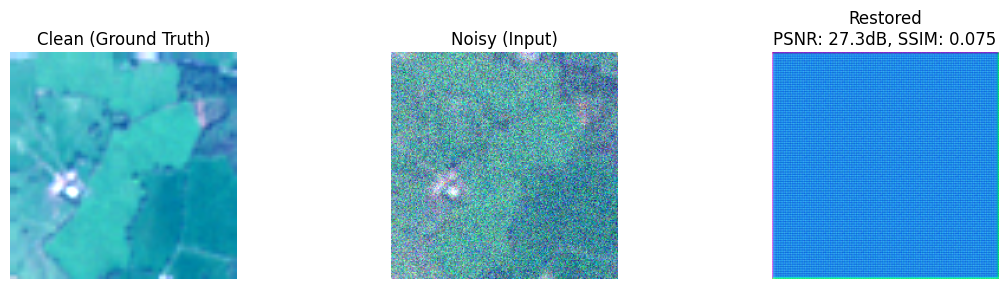


⚠️ Note: Output looks random because model has untrained (random) weights!
After training, expect PSNR > 40 dB and SSIM > 0.98


In [11]:
from src.training.metrics import calculate_psnr, calculate_ssim

# Compute basic metrics
psnr = calculate_psnr(output, target_batch)
ssim = calculate_ssim(output, target_batch)

print(f"Untrained Model Metrics:")
print(f"  PSNR: {psnr:.2f} dB (random weights, expect low values)")
print(f"  SSIM: {ssim:.4f}\n")

# Visualize using notebook helper
visualize_restoration_comparison(
    target_batch.cpu(), 
    input_batch.cpu(), 
    output.cpu(), 
    num_samples=1, 
    bands=[3, 2, 1]  # RGB bands
)

print("\n⚠️ Note: Output looks random because model has untrained (random) weights!")
print("After training, expect PSNR > 40 dB and SSIM > 0.98")

## ✅ 12. Setup Complete!

### Summary

✓ **Environment Setup**
- Configuration loaded
- Device configured

✓ **Data Downloads**
- EuroSAT Multi-Spectral dataset (27,000 images, 13 bands)
- SatMAE pre-trained weights (ViT-Base)

✓ **Model Creation**
- SatMAE restoration architecture
- Forward pass verified
- VRAM usage estimated: ~3GB

✓ **Sample Visualization**
- Noise simulation working
- RGB composite visualization

---

### 🚀 Next Steps

**Option 1: Interactive Training** (Recommended for learning)
```bash
jupyter notebook notebooks/02_training.ipynb
```

**Option 2: Script-based Training** (Recommended for production)
```bash
# Quick test (10 epochs)
python scripts/train.py --config configs/experiments/quick_test.yaml

# Full training (100 epochs, ~6 hours)
python scripts/train.py --config configs/base.yaml
```

**Option 3: Experiment with Noise Levels**
```bash
python scripts/train.py --config configs/experiments/low_noise.yaml
python scripts/train.py --config configs/experiments/medium_noise.yaml
python scripts/train.py --config configs/experiments/high_noise.yaml
```